In [18]:
# 1. 데이터 다운로드 및 압축 해제
import pandas as pd
import numpy as np
import gdown, zipfile, os

# url = 'https://drive.google.com/file/d/1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV/view?usp=sharing'
file_id = '1rhXolT2ezQBT2T6RpVJwMX3uBWsbYEcV'
output = 'Car.zip'

gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=True) # (다운로드받을것, 다운로드파일이름지정, 로그확인)

dir = 'car'
os.makedirs(dir, exist_ok=True) # exist_ok -> 없으면 만들고 있어도 에러 발생 없이 넘어감

with zipfile.ZipFile(output, 'r') as z:
  z.extractall(dir)

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

base_dir = 'car'

paths = []
dataset_types = []
labels = []

# os.walk() 특정 디렉토리 하위의 디렉토리/파일을 재귀적으로 탐색
for dir_name, sub_dirs, file_names in os.walk(base_dir):
  for file_name in file_names:
    if '.jpg' in file_name:
      file_path = f'{dir_name}/{file_name}'
      paths.append(file_path)

      if 'Training' in dir_name:
        dataset_types.append('train')
      else:
        dataset_types.append('test')

      if 'SUV' in dir_name:
        labels.append('SUV')
      elif 'Sedan' in dir_name:
        labels.append('Sedan')
      elif 'Truck' in dir_name:
        labels.append('Truck')
      else:
        labels.append('Van')


In [20]:
data_df = pd.DataFrame({
    'path': paths,
    'dataset_type': dataset_types,
    'label': labels
})

data_df.head()

,path,dataset_type,label
0,car/Car/Training/Van/Carnival/Van_Carnival_105...,train,Van
1,car/Car/Training/Van/Carnival/Van_Carnival_103...,train,Van
2,car/Car/Training/Van/Carnival/Van_Carnival_100...,train,Van
3,car/Car/Training/Van/Carnival/Van_Carnival_102...,train,Van
4,car/Car/Training/Van/Carnival/Van_Carnival_107...,train,Van


<ipython-input-21-8fca0b039852>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = vc.index, y = vc, palette = "rocket")


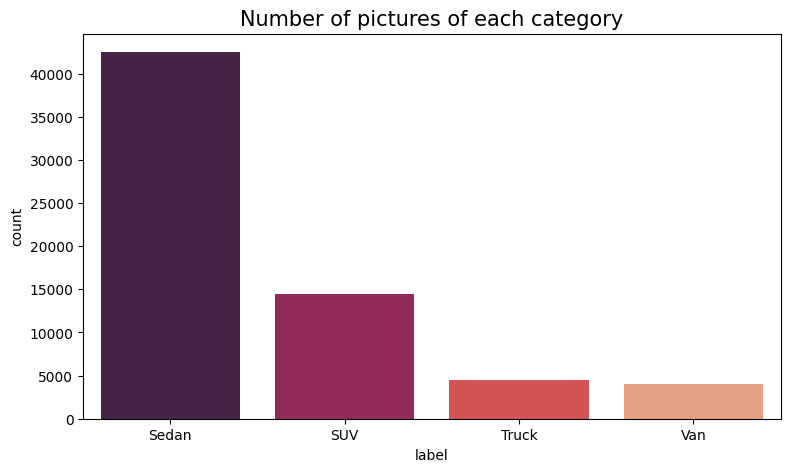

In [21]:
# @title value_counts() 시각화
import matplotlib.pyplot as plt
import seaborn as sns

vc = data_df['label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [22]:
data_df['dataset_type'].value_counts()

,count
dataset_type,
train,51079
test,14453


In [23]:
data_df['label'].value_counts()

,count
label,
Sedan,42517
SUV,14484
Truck,4525
Van,4006


In [24]:
# data_df[['dataset_type', 'label']].value_counts()

In [25]:
# @title 이미지 시각화
from matplotlib import pyplot as plt
import cv2

def show_img(path, title=None):
  fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(32, 6))
  for i in range(8):
    img = cv2.imread(path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    if title:
      ax[i].set_title(title)
    ax[i].axis('off')
  plt.show()

SUV_paths = data_df[data_df['label'] == 'SUV']['path'].values
Sedan_paths = data_df[data_df['label'] == 'Sedan']['path'].values
Truck_paths = data_df[data_df['label'] == 'Truck']['path'].values
Van_paths = data_df[data_df['label'] == 'Van']['path'].values

show_img(SUV_paths[0:8], title='SUV')
show_img(Sedan_paths[0:8], title='Sedan')
show_img(Truck_paths[0:8], title='Truck')
show_img(Van_paths[0:8], title='Van')

Output hidden; open in https://colab.research.google.com to view.

In [26]:
# 학습/검증/평가 메타데이터 분할
from sklearn.model_selection import train_test_split

train_df = data_df[data_df['dataset_type'] == 'train']
test_df = data_df[data_df['dataset_type'] == 'test']

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=0)

train_df.shape, val_df.shape, test_df.shape

((40863, 3), (10216, 3), (14453, 3))

In [27]:
# @title 데이터 전처리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 299
BATCH_SIZE = 64

tr_data_gen = ImageDataGenerator(rescale=1/255.0, horizontal_flip=True)
val_data_gen = ImageDataGenerator(rescale=1/255.0)
test_data_gen = ImageDataGenerator(rescale=1/255.0)

tr_flow_gen = tr_data_gen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    class_mode='sparse', # 라벨 정수형
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    rotation_range=30,
    zoom_range=0.2,  # 확대/축소
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    shear_range=0.2,  # 기울이기
    fill_mode='nearest'  # 채우기 방식
)
val_flow_gen = val_data_gen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    rotation_range=30,
    zoom_range=0.2,  # 확대/축소
    width_shift_range=0.2,  # 가로 이동
    height_shift_range=0.2,  # 세로 이동
    shear_range=0.2,  # 기울이기
    fill_mode='nearest'  # 채우기 방식
)
test_flow_gen = test_data_gen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    class_mode='sparse',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 40863 validated image filenames belonging to 4 classes.
Found 10216 validated image filenames belonging to 4 classes.
Found 14453 validated image filenames belonging to 4 classes.


In [28]:
# 모델 정의
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# fine tuning
for layer in base_model.layers[:-50]:
    layer.trainable = False

# functional api
x = base_model.output # feature층의 마지막값
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# model.summary()

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from time import perf_counter

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001), # 객체로 변환 후 명시적으로 생성해서 사용하는 방법
    metrics=['accuracy']
)

early_stopping_cb = EarlyStopping(patience=2, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(patience=1, factor=0.5, verbose=1)

start = perf_counter() # 학습시간 측정 시작

history = model.fit(
    tr_flow_gen,
    epochs=15,
    validation_data=val_flow_gen,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb]
)

# 학습시간 측정
duration = perf_counter() - start
duration = round(duration,2)
print(f"InceptionV3 trained in {duration} sec")

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 165s 222ms/step - accuracy: 0.9094 - loss: 0.2680 - val_accuracy: 0.9738 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 2/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 119s 184ms/step - accuracy: 0.9802 - loss: 0.0727 - val_accuracy: 0.9798 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 3/15
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9861 - loss: 0.0506
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
639/639 ━━━━━━━━━━━━━━━━━━━━ 120s 186ms/step - accuracy: 0.9861 - loss: 0.0506 - val_accuracy: 0.9780 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 4/15
639/639 ━━━━━━━━━━━━━━━━━━━━ 117s 182ms/step - accuracy: 0.9902 - loss: 0.0357 - val_accuracy: 0.9850 - val_loss: 0.0642 - learning_rate: 5.0000e-04
Epoch 5/15
638/639 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9940 - loss: 0.0215
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
639/639 ━━━━━━━━━━━━━━━━━━━━ 118s 183ms/step - accuracy: 0.9940 - 

226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.9760 - loss: 0.1270
loss: 0.0688, accuracy=0.9846


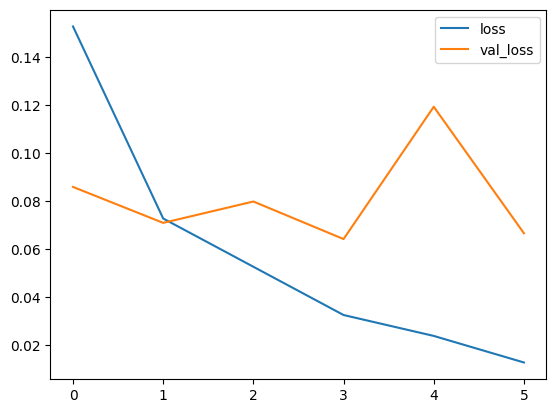

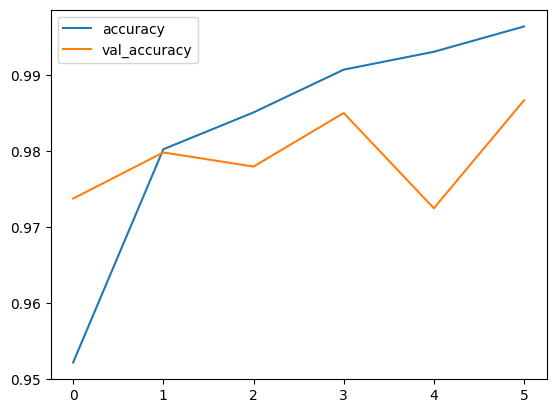

In [30]:
# 평가
loss, accuracy = model.evaluate(test_flow_gen)
print(f'loss: {loss:.4f}, accuracy={accuracy:.4f}')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()